In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# cnn in pytorch

/Users/seamus/opt/anaconda3/envs/ptenv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
mnist_trainset = pd.read_csv("data/mnist_train.csv")
mnist_testset = pd.read_csv("data/mnist_test.csv")

In [3]:
train_labels = mnist_trainset["label"].to_numpy()
test_labels = mnist_testset["label"].to_numpy()

train_images = mnist_trainset.drop(columns=["label"]).to_numpy().reshape(60000, 28, 28) / 255.0
test_images = mnist_testset.drop(columns=["label"]).to_numpy().reshape(10000, 28, 28) / 255.0

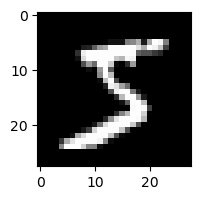

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(train_images[0], cmap="gray")

In [5]:
im_train, im_val, lab_train, lab_val = train_test_split(train_images, train_labels, test_size = 0.1)
(im_train.shape, lab_train.shape), (im_val.shape, lab_val.shape)

(((54000, 28, 28), (54000,)), ((6000, 28, 28), (6000,)))

In [6]:
#convert to torch format
im_train = im_train.reshape(54000, 1, 28, 28).astype(np.float32)
im_train = torch.from_numpy(im_train)

lab_train = torch.from_numpy(lab_train)

In [7]:
im_val = im_val.reshape(6000, 1, 28, 28).astype(np.float32)
im_val = torch.from_numpy(im_val)

lab_val = torch.from_numpy(lab_val)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1), #one input channel (grayscale), 32 filters, 3x3 kernels
            nn.BatchNorm2d(4), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1), #one input channel (grayscale), 32 filters, 3x3 kernels
            nn.BatchNorm2d(8), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8 * 7 * 7, out_features=64),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=64, out_features=10)
        )
    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.linear_layers(x)
        return x

In [9]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
loss = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    print("hi")
    model = model.cuda()
    loss = loss.cuda()


In [10]:
def train(epoch, train_losses, val_losses):
    model.train()
    tr_loss = 0

    if torch.cuda.is_available():
        im_train.cuda()
        lab_train.cuda()
        im_val.cuda()
        lab_val.cuda()
    
    optimizer.zero_grad() # clearing the gradients of the model parameters

    # predictions
    output_train = model(im_train)
    output_val = model(im_val)
    
    # compute loss
    loss_train = loss(output_train, lab_train)
    loss_val = loss(output_val, lab_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # update all parameter weights
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()

    print(f"Epoch: {epoch+1}, Loss: {loss_val}")
    return loss_val
    

In [11]:
def main():
    n_epochs = 100
    prev_loss = 100 #number larger than any loss possible

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        loss = train(epoch, train_losses, val_losses)
        if loss > prev_loss:
            break
        prev_loss = loss

In [12]:
main()

Epoch: 1, Loss: 2.3297336101531982
Epoch: 2, Loss: 2.182982921600342
Epoch: 3, Loss: 2.0637834072113037
Epoch: 4, Loss: 1.9351667165756226
Epoch: 5, Loss: 1.7973912954330444
Epoch: 6, Loss: 1.6606872081756592
Epoch: 7, Loss: 1.5224246978759766
Epoch: 8, Loss: 1.384137511253357
Epoch: 9, Loss: 1.254077672958374
Epoch: 10, Loss: 1.1351348161697388
Epoch: 11, Loss: 1.0274492502212524
Epoch: 12, Loss: 0.9320433139801025
Epoch: 13, Loss: 0.8479202389717102
Epoch: 14, Loss: 0.7721070051193237
Epoch: 15, Loss: 0.7049536108970642
Epoch: 16, Loss: 0.6462365984916687
Epoch: 17, Loss: 0.5954270362854004
Epoch: 18, Loss: 0.5517388582229614
Epoch: 19, Loss: 0.5136697888374329
Epoch: 20, Loss: 0.4803393483161926
Epoch: 21, Loss: 0.4511268436908722
Epoch: 22, Loss: 0.4249560534954071
Epoch: 23, Loss: 0.40167146921157837
Epoch: 24, Loss: 0.3813962936401367
Epoch: 25, Loss: 0.36322641372680664
Epoch: 26, Loss: 0.3466953635215759
Epoch: 27, Loss: 0.3317846357822418
Epoch: 28, Loss: 0.3180895149707794
Ep

In [13]:
with torch.no_grad():
    output = model(im_train)
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(lab_train, predictions)

0.9729629629629629

In [14]:
with torch.no_grad():
    output = model(im_val)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(lab_val, predictions)

0.9691666666666666

In [16]:
im_test = test_images.reshape(10000, 1, 28, 28).astype(np.float32)
im_test = torch.from_numpy(im_test)

lab_test = torch.from_numpy(test_labels)

In [18]:
with torch.no_grad():
    output = model(im_test)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
act_predictions = np.argmax(prob, axis=1)

accuracy_score(lab_test, act_predictions)

0.9725